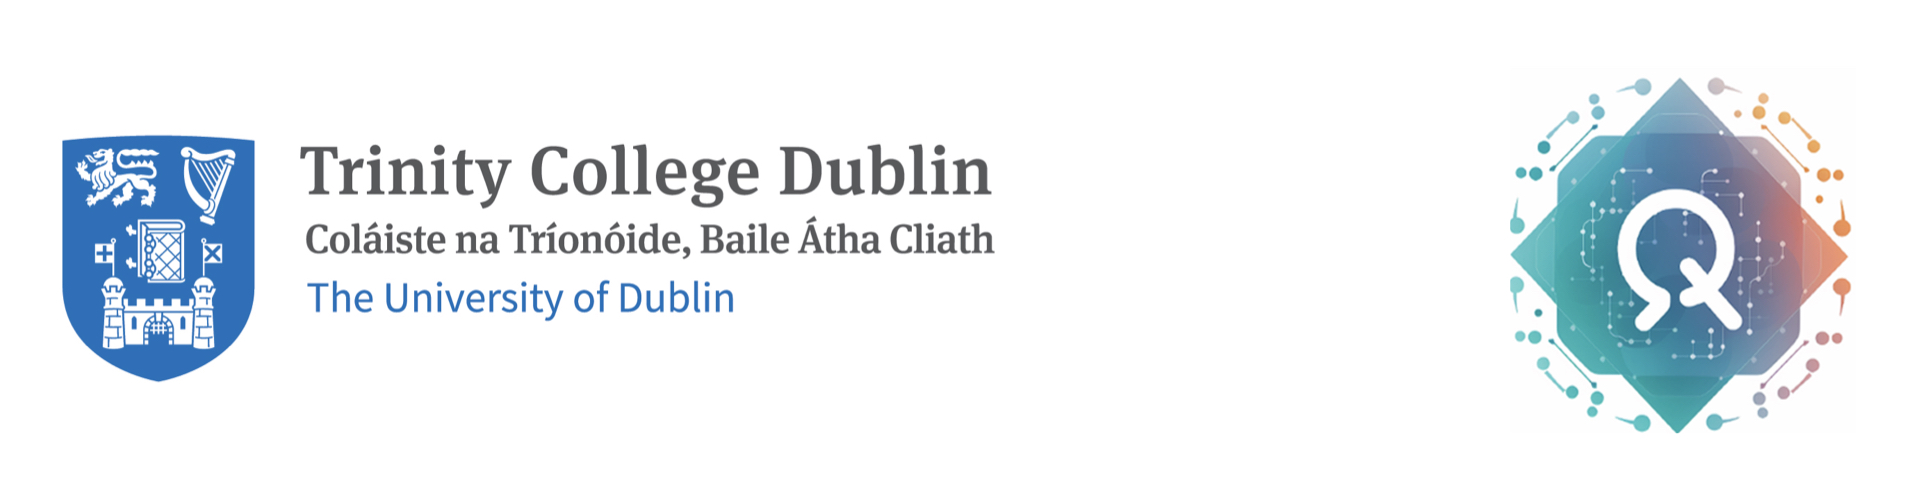

# Qiskit Tutorial on Grover's Quantum Algorithm
Adapted from https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm#3qubits

In [14]:
import qiskit
import numpy as np
from matplotlib import pyplot as plt
from qiskit import Aer
from qiskit.visualization import plot_histogram

In [16]:
# We are given an oracle that identifies |101> and |110>.
# Create a Quantum Circuit.
qc = qiskit.QuantumCircuit(3) # The argument specifies the number of qubits in the circuit.
qc.cz(0, 2) # Controlled Z gate (arguments: control, target)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate() # Transforms the circuit in a gate that can be appended to another circuit.
oracle_ex3.name = "Ug"

In [37]:
# How does the oracle work?
circuit_test_oracle = qiskit.QuantumCircuit(3)
# Set the initial state: |101>
circuit_test_oracle.x(0)
circuit_test_oracle.x(2)

# Here the oracle code
circuit_test_oracle.cz(0, 2)
circuit_test_oracle.cz(1, 2)

# Statevector simulator keeps track of the quantum state
statevector_sim = Aer.get_backend('statevector_simulator')
results = statevector_sim.run(circuit_test_oracle).result()
results.get_statevector() # Retrieve the quantum state (we want to see a phase!)

Statevector([ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j, -0.+0.j,
              0.-0.j],
            dims=(2, 2, 2))


In [9]:
# This is the reflection Rψ0 operator.
def diffuser(nqubits):
    qc = qiskit.QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

def initialize_s(qc, qubits):
    # Apply Hadamard gate to all qubits, to create a uniform superposition.
    for q in qubits:
        qc.h(q)
    return qc

In [41]:
n = 3

# The search space has size L=8.
L = 8
# The solutions are m=2.
m = 2
# How many Grover iterations?
# m/L = sin^2(θ0) => θ0 = arcsin(sqrt(m/L))
θ0 = np.arcsin(np.sqrt(m/L))
jL = int(np.pi / (4*θ0))
print("Optimal number of Grover iterations: " + str(jL))

grover_circuit = qiskit.QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

Optimal number of Grover iterations: 1


┌───┐┌─────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0    ├┤0       ├─░─┤M├──────
        ├───┤│     ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 Ug ├┤1 U$_s$ ├─░──╫─┤M├───
        ├───┤│     ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2    ├┤2       ├─░──╫──╫─┤M├
        └───┘└─────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════╩══╩══╩═
                                  0  1  2

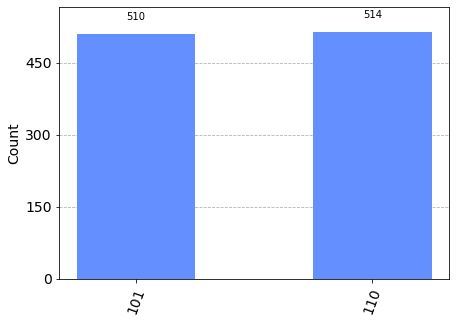

In [15]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_grover_circuit = qiskit.transpile(grover_circuit, qasm_sim)
results = qasm_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
plot_histogram(counts)